In [11]:
import sys
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import json
from skimage import io, data, measure, color
from torchvision import transforms
import PIL
from PIL import Image
import glob
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from data_loaders import *
from problems import *
import scipy.misc
import utilities
from ResDNet import *
from MMNet import *
%matplotlib inline
    

# Define HyperParameters

In [54]:
demo_path = 'misc/demo.png'
demo_img = io.imread(demo_path)

args_noise_estimation = True # wheter to estimate noise or not
args_init = True # wheter to initialize the input with bilinear
args_use_gpu = True 
args_block_size = (512,512)
args_model = 'pretrained_models/denoising/' # model path
# Define folder with RAW images
args_output_folder = 'output/' # save results to folder
args_type = '.png' # image type to save as
   
reference = 3 # Index of reference frame using 0-based numbering
tmp_path = 'tmp/'
files = glob.glob(tmp_path+'*.pkl')
for f in files:
    os.remove(f)

# Load Model

In [55]:
model_params = torch.load(args_model+'model_best.pth')

model = ResDNet(BasicBlock, model_params[2], weightnorm=True)
mmnet = MMNet(model, max_iter=model_params[1])
for param in mmnet.parameters():
    param.requires_grad = False

mmnet.load_state_dict(model_params[0])
if args_use_gpu:
    mmnet = mmnet.cuda()

In [111]:
def calculate_affine_matrices(burst):
    warp_matrices = np.zeros((burst.shape[0],2,3))
    warp_matrices[-1] = np.eye(2,3) # identity for reference frame
    for i, b in enumerate(burst[:-1]):
        warp_matrix = calculate_ECC((burst[-1]/255).astype(np.float32),(b/255).astype(np.float32), 2) 
        if warp_matrix is None:
            return None

        warp_matrices[i] = warp_matrix
    return warp_matrices

def calculate_ECC(img_ref, img, nol=4):
    img_ref = skimage.color.rgb2gray(img_ref).astype(np.float32)
    img = skimage.color.rgb2gray(img).astype(np.float32)
    # ECC params
    init_warp = np.array([[1, 0, 0], [0, 1, 0]], dtype=np.float32)
    n_iters = 5000
    e_thresh = 1e-5
    warp_mode = cv2.MOTION_EUCLIDEAN
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, n_iters, e_thresh)

    warp = init_warp

    # construct grayscale pyramid
    gray1_pyr = [img_ref]
    gray2_pyr = [img]

    for level in range(nol-1):
        gray1_pyr.insert(0, cv2.resize(gray1_pyr[0], None, fx=1/2, fy=1/2,
                                       interpolation=cv2.INTER_AREA))
        gray2_pyr.insert(0, cv2.resize(gray2_pyr[0], None, fx=1/2, fy=1/2,
                                       interpolation=cv2.INTER_AREA))

    # run pyramid ECC
    error_cnt = 0
    for level in range(nol):
        try:
            cc, warp_ = cv2.findTransformECC(gray1_pyr[level], gray2_pyr[level],
                                            warp, warp_mode, criteria)
            warp = warp_
            if level != nol-1:  # scale up for the next pyramid level
                warp = warp * np.array([[1, 1, 2], [1, 1, 2]], dtype=np.float32)
        except Exception as e:
            print(level, e)
            error_cnt += 1
            pass

    if error_cnt == nol:
        return None
    else:
        return warp


MAX_TRAN = 16
MAX_ANGLE = 5 * np.pi / 180

def inv_warp(warp):
    r""" calculate inverse of affine transformation"""
    r = warp[:,:2]
    t = warp[:,2]
    r_inv = np.linalg.inv(r)
    t_inv = -r_inv.dot(t)
    warp_inv = np.zeros_like(warp)
    warp_inv[:,:2] = r_inv
    warp_inv[:,2] = t_inv
    return warp_inv

def random_warp(img, burst_size):
    r""" random affine warp a burst and return oracle warp matrices"""
    burst = np.array([img]*burst_size)
    warp_matrices =[]
    for i in range(burst_size-1):
        angle = np.random.uniform(-MAX_ANGLE,MAX_ANGLE)
        t_x = np.random.uniform(-MAX_TRAN,MAX_TRAN)
        t_y = np.random.uniform(-MAX_TRAN,MAX_TRAN)

        warp_matrix = np.array([[1,0, t_x],[0,1, t_y]])
        img_w = cv2.warpAffine(img, warp_matrix, (img.shape[1], img.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT_101)
        burst[i] = img_w
        warp_matrices.append(warp_matrix)
    warp_matrices.append(np.array([[1,0,0],[0,1,0]]))
    return burst, warp_matrices


In [117]:
std = 25  # Standard deviation of noise to generate noisy frames
num_frames = 8  # number of frames
use_oracle_warp = True  

In [123]:
image_gt = torch.Tensor(demo_img.transpose(2,0,1)[None])
batch,C, H, W = image_gt.shape

# pad image to size 
pad_size = 512 
image_gt = F.pad(image_gt,(0,pad_size - W, 0, pad_size - H),mode='reflect')

# create burst
im = image_gt[0].cpu().numpy()
im = im.transpose(1,2,0)

burst, warp_matrices = random_warp(im,num_frames)
burst = burst.clip(0,255).astype(np.uint8)

burst = burst + std * np.random.standard_normal(burst.shape)
burst = burst.clip(0,255)

if not use_oracle_warp:
    warp_matrices =  calculate_affine_matrices(burst)

# create burst denoise inputs
burst_T = torch.FloatTensor(burst).permute(0,3,1,2)[None]
warp_matrix = torch.Tensor(warp_matrices).float()[None]


# apply model
p = Burst_Denoise(burst_T, warp_matrix)
p.cuda_()
xcur = mmnet.forward_all_iter(p, max_iter=mmnet.max_iter, init=True, noise_estimation=True)

# calculate psnr
out = xcur[0].data.cpu().permute(1,2,0).numpy()/255
gt = image_gt[0].data.cpu().permute(1,2,0).numpy()/255
out = out[:H,:W]  # remove padding
gt = gt[:H,:W]  # remove padding
psnr = measure.compare_psnr(out, gt , data_range=1)
print('PSNR:', psnr)

PSNR: 35.95249217847748


Groundtruth


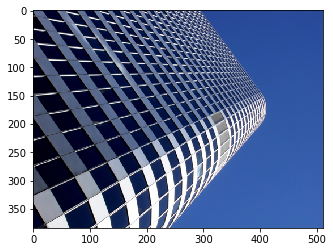

In [119]:
plt.imshow(gt)
print('Groundtruth')

Output


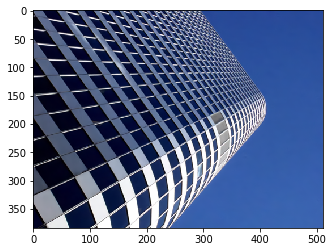

In [120]:
plt.imshow(out.clip(0,1))
print('Output')

Reference frame w/ padding


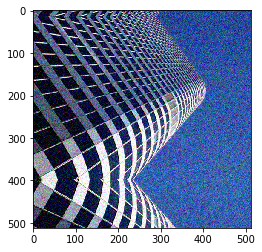

In [116]:
plt.imshow(burst[0]/255)
print('Reference frame w/ padding')

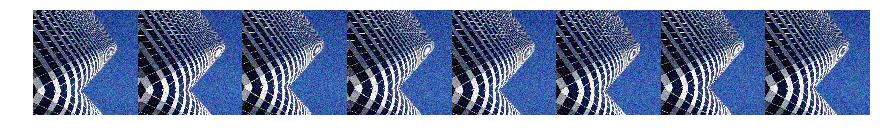

In [132]:
def plot_batch_burst(burst):
    batch, n, _, _, _ = burst.shape
    burst = burst.reshape(-1, burst.shape[2], burst.shape[3], burst.shape[4])
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(wspace=0, hspace=0.1)
    for i in range(1, batch * n + 1):
        plt.subplot(batch, n, i)
        plt.imshow(burst[i - 1].cpu().data.permute(1, 2, 0).numpy().astype(np.uint8))
        plt.axis('off')

plot_batch_burst(burst_T)